# Goals

1. How do you ensure that customers can/will pay their loans?
2. Can we approve customers with high certainty?

# Imports

In [1]:
#imports
#numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt

#estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

#cross validation
from sklearn.model_selection import train_test_split

#selection method
from sklearn.feature_selection import SelectKBest, f_classif

# Data

In [2]:
#data
rawData = pd.read_csv('Credit_One_Data.csv')
rawData.drop(rawData.columns[0], axis=1, inplace=True)

rawData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,DEFAULTED_NMOS,DEFAULTED
0,20000,1,1,1,24,2,2,-1,-1,-2,...,0,0,689,0,0,0,0,0,2,1
1,120000,1,1,2,26,-1,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,0,2,1
2,90000,1,1,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,1,0,0
3,50000,1,1,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,1,0,0
4,50000,0,1,1,57,-1,0,-1,0,0,...,19131,2000,36681,10000,9000,689,679,1,0,0


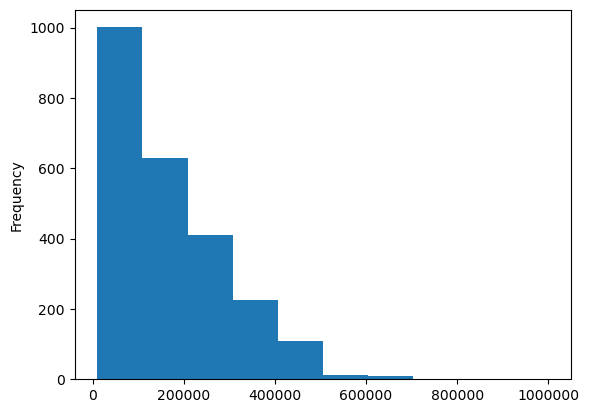

In [3]:
# histogram showing the frequency of the different credit limit amounts
rawData['LIMIT_BAL'].apply(float).plot.hist().ticklabel_format(style='plain')

The bulk of credit limits are under $400,000

In [4]:
# basic statistics for each column of the data
rawData.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,DEFAULTED_NMOS,DEFAULTED
count,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,...,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,165834.724541,0.577629,1.230801,1.580134,35.419866,0.004591,-0.136477,-0.151920,-0.249165,-0.259599,...,38797.298414,5548.942821,5220.050501,4855.443656,4891.429883,4984.977880,5149.928631,0.783389,0.846828,0.347663
std,129493.683277,0.494040,0.721101,0.525593,9.452344,1.123473,1.207902,1.247411,1.176359,1.156723,...,65468.199929,13701.948666,14616.927369,22156.285391,14252.068389,16896.223773,20076.659470,0.412021,1.563518,0.476328
min,10000.000000,0.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1012.000000,997.500000,588.000000,247.750000,240.000000,247.750000,0.000000,1.000000,0.000000,0.000000
50%,140000.000000,1.000000,1.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15819.500000,2117.500000,2000.000000,1443.000000,1500.000000,1500.000000,1328.000000,1.000000,0.000000,0.000000
75%,230000.000000,1.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,47369.500000,5002.250000,4921.750000,4000.000000,4000.000000,4000.000000,4000.000000,1.000000,1.000000,1.000000
max,1000000.000000,1.000000,3.000000,3.000000,75.000000,8.000000,7.000000,7.000000,7.000000,7.000000,...,961664.000000,239104.000000,285138.000000,896040.000000,205000.000000,332000.000000,528666.000000,1.000000,6.000000,1.000000


Classifying the LIMIT_BAL into 4 bins:
0-50000
50000-140000
140000-230000
230000-1000000

In [5]:
def LIMIT_BINS(LIMIT_BAL):

  if LIMIT_BAL < 50000:
    return '0-50000'
  if LIMIT_BAL < 140000:
    return '50000-140000'
  if LIMIT_BAL < 230000:
    return '140000-200000'
  else:
    return '200000-1000000'

In [6]:
rawData['CREDIT_LIMIT'] = rawData['LIMIT_BAL'].apply(LIMIT_BINS)

In [7]:
#dependent variable
y = rawData['default_payment_next_month']

#features
X = rawData.iloc[0:,0:23]
print('Summary of feature sample')
X.head()

Summary of feature sample


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,1,1,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,1,1,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,1,1,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,1,1,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,0,1,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [9]:
#validate feature selection using SelectKBest
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

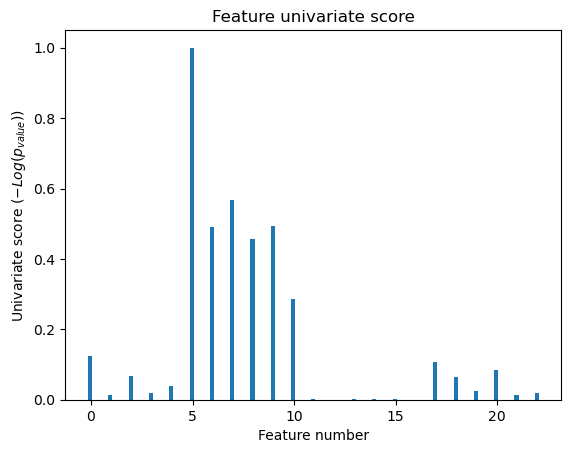

In [10]:
import matplotlib.pyplot as plt

X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

Features 5-10 are significant in predicting default_payment_next_month, they have the highest score with univariate feature selection

In [11]:
#compare with SVMs
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.815


In [12]:
svm_weights

array([0.00736844, 0.00132825, 0.00143803, 0.01650148, 0.02350442,
       0.20459537, 0.03280624, 0.06871609, 0.01198419, 0.0905888 ,
       0.05713652, 0.06694421, 0.0058553 , 0.04841243, 0.01581144,
       0.06683309, 0.05349198, 0.1239052 , 0.04011398, 0.00677608,
       0.03230171, 0.01921281, 0.00437394])

In [13]:
#after univariate feature selection
clf_selected = make_pipeline(SelectKBest(f_classif, k='all'), MinMaxScaler(), LinearSVC())
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.815


In [14]:
svm_weights_selected

array([0.00736835, 0.00132831, 0.00143808, 0.01650145, 0.02350444,
       0.20459482, 0.03280661, 0.06871621, 0.0119842 , 0.09058896,
       0.05713627, 0.06694406, 0.00585543, 0.04841239, 0.01581143,
       0.06683342, 0.05349208, 0.12390515, 0.04011383, 0.00677606,
       0.0323016 , 0.01921277, 0.00437405])

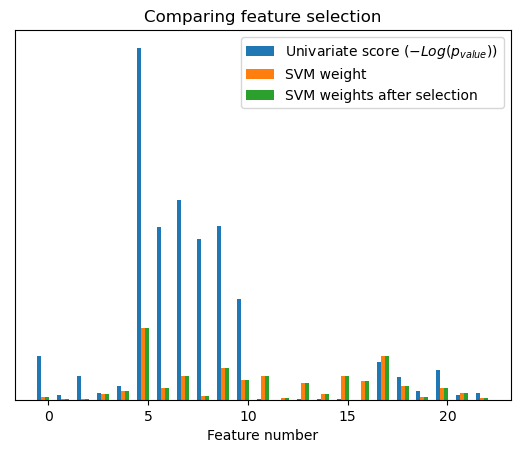

In [15]:
plt.bar(
    X_indices - 0.45, scores, width=0.2, label=r"Univariate score ($-Log(p_{value})$)"
)

plt.bar(X_indices - 0.25, svm_weights, width=0.2, label="SVM weight")

plt.bar(
    X_indices[selector.get_support()] - 0.05,
    svm_weights_selected,
    width=0.2,
    label="SVM weights after selection",
)
plt.title("Comparing feature selection")
plt.xlabel("Feature number")
plt.yticks(())
plt.axis("tight")
plt.legend(loc="upper right")
plt.show()

In [16]:
#redefining X based on SelectKBest
#features
X = rawData.iloc[:, [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]
print('Summary of feature sample')
X.head()

Summary of feature sample


,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [17]:
#redefine train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [18]:
algosClass = []

algosClass.append(('Random Forest Regressor',RandomForestRegressor()))

algosClass.append(('Linear Regression',LinearRegression()))

algosClass.append(('Support Vector Regression', SVR()))

#regression
results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.09970660000455785
Linear Regression 0.07242378022493834
Support Vector Regression -0.08149319567545306


With the input data set, none of these models will perform well to ensure that customers will be able to pay their loans.

Of the 3 options, Linear Regression should perform the best as it has the highest r2 value

# Determine if customers can pay their loans

In [19]:
algo = RandomForestRegressor()
#algo = LinearRegression()
#algo = SVR()

In [20]:
model = algo.fit(X_train,y_train)

In [21]:
#make predictions
predictions = model.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.194
RMSE: 0.376


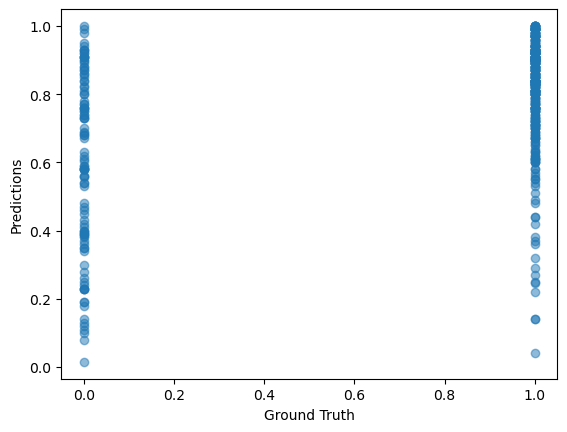

In [22]:
plt.scatter(y_test, predictions, alpha = .5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show();

# Determine the Credit Limit

In [73]:
#reusing rawData from the above

rawData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,DEFAULTED_NMOS,DEFAULTED,CREDIT_LIMIT
0,20000,1,1,1,24,2,2,-1,-1,-2,...,0,689,0,0,0,0,0,2,1,0-50000
1,120000,1,1,2,26,-1,2,0,0,0,...,0,1000,1000,1000,0,2000,0,2,1,50000-140000
2,90000,1,1,2,34,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,1,0,0,50000-140000
3,50000,1,1,1,37,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,1,0,0,50000-140000
4,50000,0,1,1,57,-1,0,-1,0,0,...,2000,36681,10000,9000,689,679,1,0,0,50000-140000


In [86]:
#dependent variable
y = rawData['LIMIT_BAL']

#features
X = rawData.iloc[0:,1:26]
print('Summary of feature sample')
X.head()

Summary of feature sample


,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,DEFAULTED_NMOS,DEFAULTED
0,1,1,1,24,2,2,-1,-1,-2,-2,...,0,0,689,0,0,0,0,0,2,1
1,1,1,2,26,-1,2,0,0,0,2,...,3261,0,1000,1000,1000,0,2000,0,2,1
2,1,1,2,34,0,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,1,0,0
3,1,1,1,37,0,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,1,0,0
4,0,1,1,57,-1,0,-1,0,0,0,...,19131,2000,36681,10000,9000,689,679,1,0,0


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [92]:
#validate feature selection using SelectKBest
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

C:\Users\higgi\AppData\Local\Temp\ipykernel_2324\2508421386.py:4: RuntimeWarning: divide by zero encountered in log10
  scores = -np.log10(selector.pvalues_)
C:\Users\higgi\AppData\Local\Temp\ipykernel_2324\2508421386.py:5: RuntimeWarning: invalid value encountered in true_divide
  scores /= scores.max()


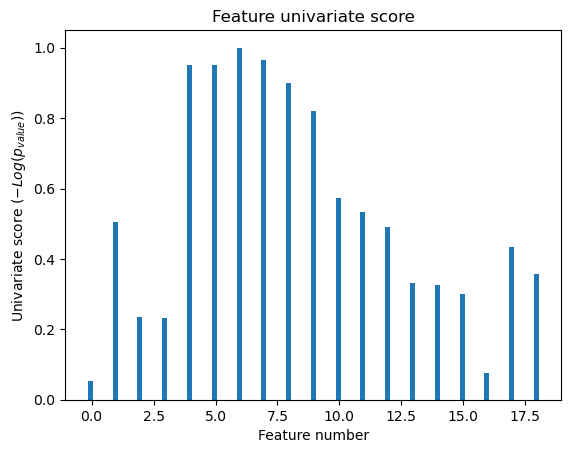

In [60]:
import matplotlib.pyplot as plt

X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

Features 1 and 4-21 appear to be significant in predicting LIMIT_BAL, they have the highest score with univariate feature selection

In [61]:
#compare with SVMs
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.448


In [62]:
svm_weights

array([0.00610991, 0.04094837, 0.02699923, 0.03165939, 0.07003564,
       0.06559445, 0.0475139 , 0.08352206, 0.06277654, 0.04999181,
       0.08775042, 0.08995295, 0.05187953, 0.0525938 , 0.09463923,
       0.09638481, 0.00257991, 0.03278801, 0.00628004])

In [63]:
#after univariate feature selection
clf_selected = make_pipeline(SelectKBest(f_classif, k='all'), MinMaxScaler(), LinearSVC())
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.448


In [64]:
svm_weights_selected

array([0.00610989, 0.04094832, 0.02699926, 0.03165937, 0.07003566,
       0.06559443, 0.04751389, 0.08352196, 0.06277659, 0.0499919 ,
       0.08775044, 0.08995291, 0.05187959, 0.05259381, 0.09463919,
       0.09638481, 0.00257991, 0.03278796, 0.0062801 ])

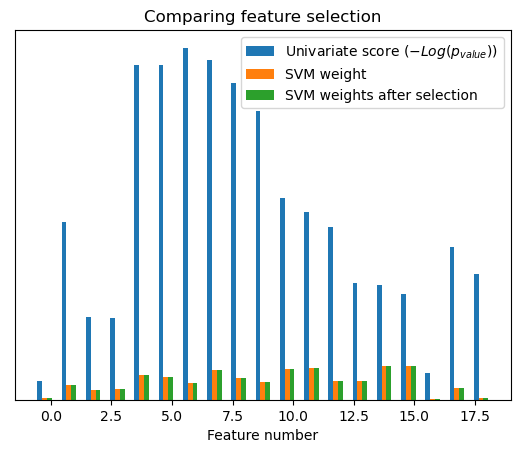

In [65]:
plt.bar(
    X_indices - 0.45, scores, width=0.2, label=r"Univariate score ($-Log(p_{value})$)"
)

plt.bar(X_indices - 0.25, svm_weights, width=0.2, label="SVM weight")

plt.bar(
    X_indices[selector.get_support()] - 0.05,
    svm_weights_selected,
    width=0.2,
    label="SVM weights after selection",
)
plt.title("Comparing feature selection")
plt.xlabel("Feature number")
plt.yticks(())
plt.axis("tight")
plt.legend(loc="upper right")
plt.show()

The SVM weights after selection appear to show that features 11-15, and 20 are significant to predicting LIMIT_BAL

In [93]:
#redefining X based on SelectKBest
#features
X = rawData.iloc[:, 1:26]
print('Summary of feature sample')
X.head()

Summary of feature sample


,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,DEFAULTED_NMOS,DEFAULTED
0,1,1,1,24,2,2,-1,-1,-2,-2,...,0,0,689,0,0,0,0,0,2,1
1,1,1,2,26,-1,2,0,0,0,2,...,3261,0,1000,1000,1000,0,2000,0,2,1
2,1,1,2,34,0,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,1,0,0
3,1,1,1,37,0,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,1,0,0
4,0,1,1,57,-1,0,-1,0,0,0,...,19131,2000,36681,10000,9000,689,679,1,0,0


In [94]:
#redefine train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [95]:
algosClass = []

algosClass.append(('Random Forest Regressor',RandomForestRegressor()))

algosClass.append(('Linear Regression',LinearRegression()))

algosClass.append(('Support Vector Regression', SVR()))

#regression
results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.4455740660586594
Linear Regression 0.38293506444885894
Support Vector Regression -0.03954910243741098


With the input data set, none of these models will perform well to ensure that customers will be able to pay their loans.

Of the 3 options, Random Forest Regression should perform the best as it has the highest r2 value

In [96]:
algo = RandomForestRegressor()
#algo = LinearRegression()
#algo = SVR()

In [97]:
model = algo.fit(X_train,y_train)

In [98]:
#make predictions
predictions = model.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.491
RMSE: 94761.125


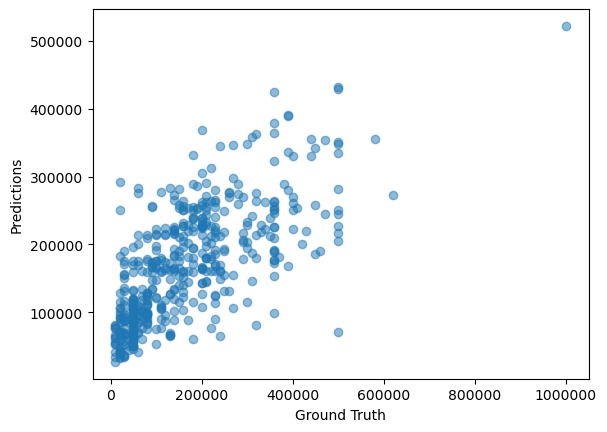

In [99]:
plt.scatter(y_test, predictions, alpha = .5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show();

### Regression Conclusions: The regression models are not an acceptable way to predict whether customers can make their payments next month, or what the credit limit should be.

# Classification (Can Customers Pay Their Bills)

In [100]:
#Classification feature selection
#X = rawData[['SEX','EDUCATION','MARRIAGE','AGE']]
X = rawData.iloc[:, [0,1,2,3,4,11,12,13,14,15,16,17,18,19,20,21,22]]

y = rawData['default_payment_next_month']

In [101]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,1,1,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,1,1,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,1,1,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,1,1,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,0,1,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [102]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: default_payment_next_month, dtype: int64

In [103]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 123)

In [104]:
#Modeling (Classification)
algo = DecisionTreeClassifier()

In [105]:
model = algo.fit(X_train,y_train)

In [106]:
#Predictions
preds = model.predict(X_test)

In [107]:
print("Overall Classification")
print("")
print(classification_report(y_test,preds,zero_division=0))

Overall Classification

              precision    recall  f1-score   support

           0       0.21      0.22      0.21        93
           1       0.81      0.81      0.81       387

    accuracy                           0.69       480
   macro avg       0.51      0.51      0.51       480
weighted avg       0.69      0.69      0.69       480



In [108]:
input = X
target = y

s1 = 'Overall Classification Score:' 
s2 = model.score(input,target)
print(s1, s2)
print("")

Overall Classification Score: 0.9386477462437396



Made into a classification problem and using a decision tree classifier, the precision, recall, and f1-scores are all .8 or above, and the overall R2 score is .93. This model should be able to predict whether customers can make their payments or if they will default.

Overall (Decision Tree Classifier)


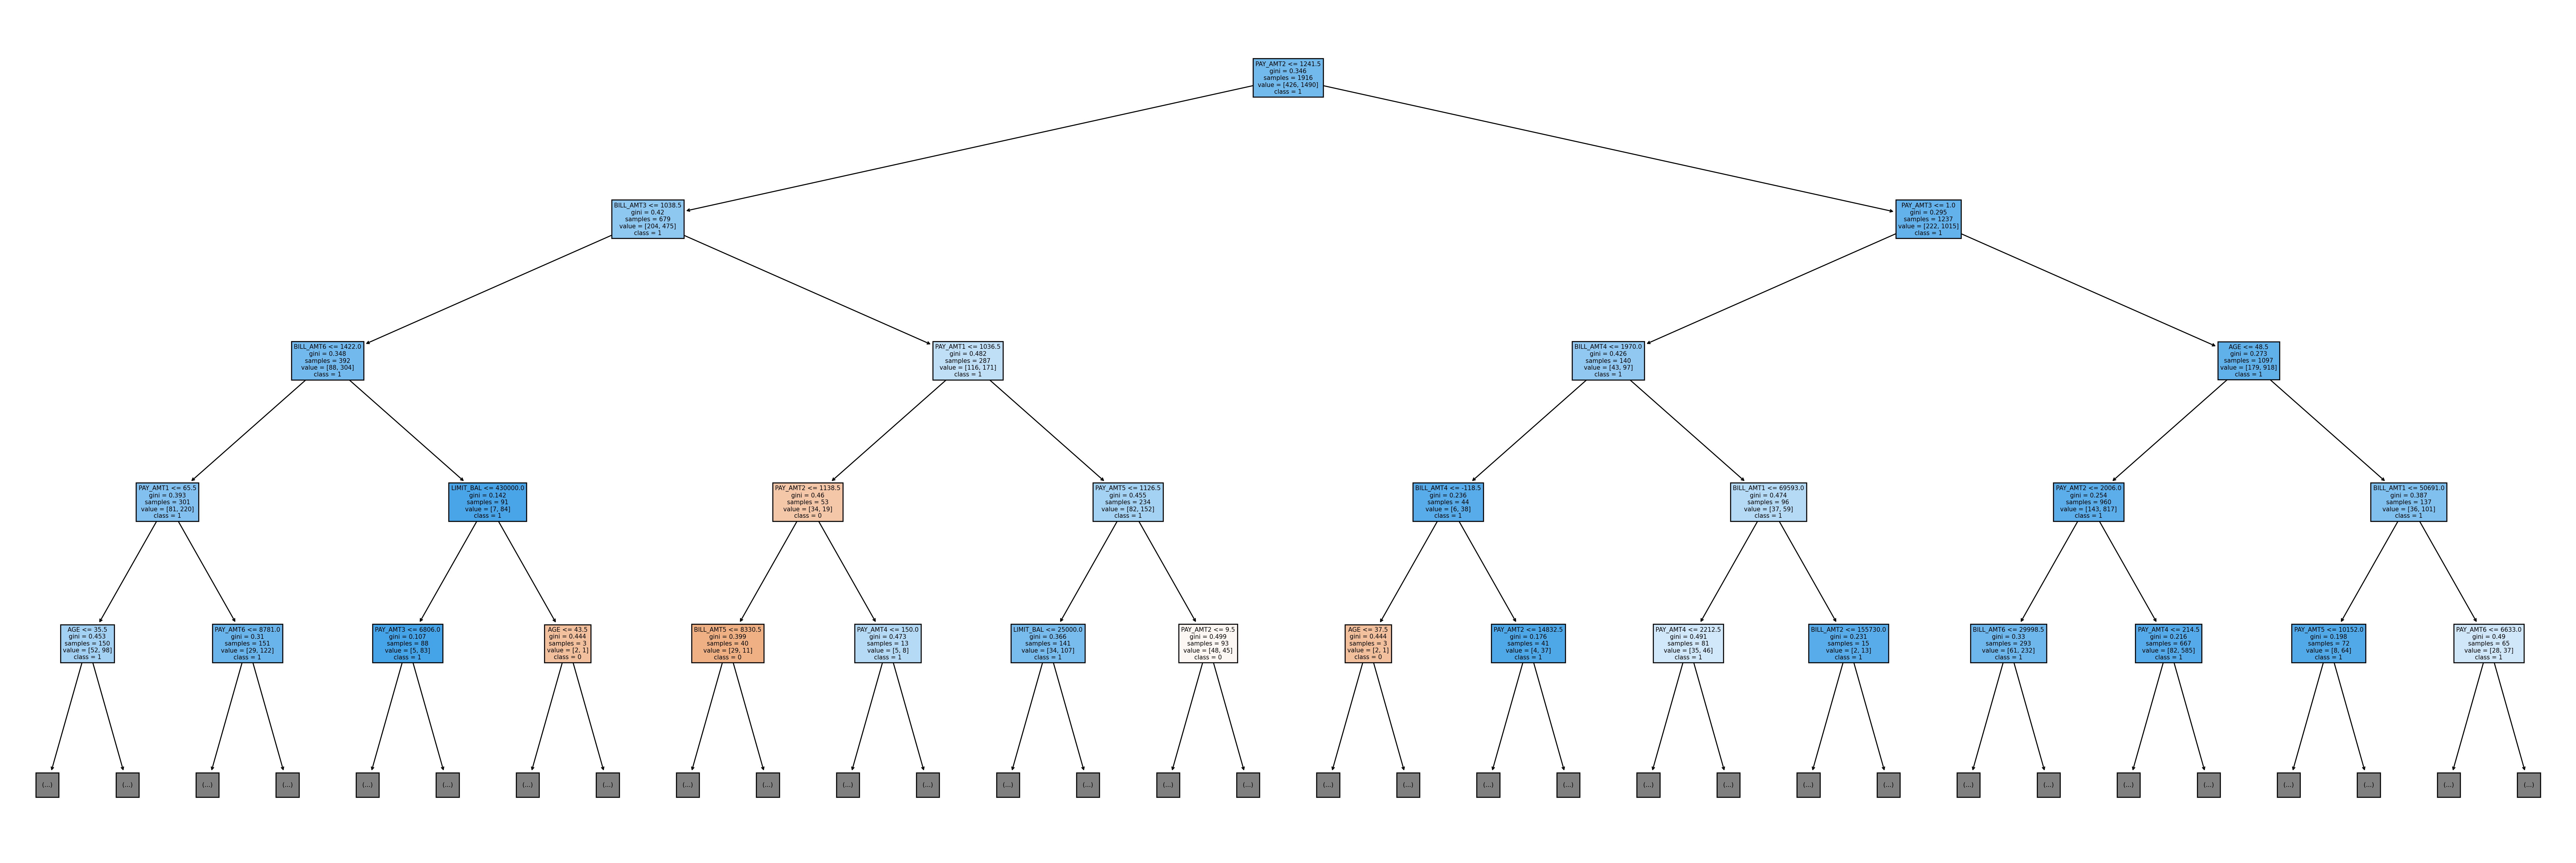

In [109]:
print('Overall (Decision Tree Classifier)')
fig = plt.figure(figsize=(45,15),dpi=250)
tree = plot_tree(model, feature_names=X.columns, class_names=['0','1'], filled=True, max_depth=4)

# Classification (Can the Credit Limit be Predicted)

In [110]:
#Classification feature selection
X = rawData.iloc[0:,[1,2,3,4,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]]

y = rawData['CREDIT_LIMIT']

In [111]:
X.head()

,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,DEFAULTED_NMOS,DEFAULTED
0,1,1,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,2,1
1,1,1,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0,2,1
2,1,1,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,1,0,0
3,1,1,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,1,0,0
4,0,1,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,1,0,0


In [112]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 123)

In [113]:
#Modeling (Classification)
algo = DecisionTreeClassifier()

In [114]:
model = algo.fit(X_train,y_train)

In [115]:
#Predictions
preds = model.predict(X_test)

In [116]:
print("Overall Classification")
print("")
print(classification_report(y_test,preds,zero_division=0))

Overall Classification

                precision    recall  f1-score   support

       0-50000       0.44      0.40      0.42        57
 140000-200000       0.35      0.38      0.36       122
200000-1000000       0.50      0.49      0.49       127
  50000-140000       0.55      0.54      0.54       174

      accuracy                           0.47       480
     macro avg       0.46      0.45      0.46       480
  weighted avg       0.47      0.47      0.47       480



In [117]:
input = X
target = y

s1 = 'Overall Classification Score:' 
s2 = model.score(input,target)
print(s1, s2)
print("")

Overall Classification Score: 0.8927378964941569



The overall model score (r2) of .89 indicates that this model should be good at predicting the credit limit. However, the lower precision, recall, and f1 scores indicate that the model might be useful only in some situations.

Overall (Decision Tree Classifier)


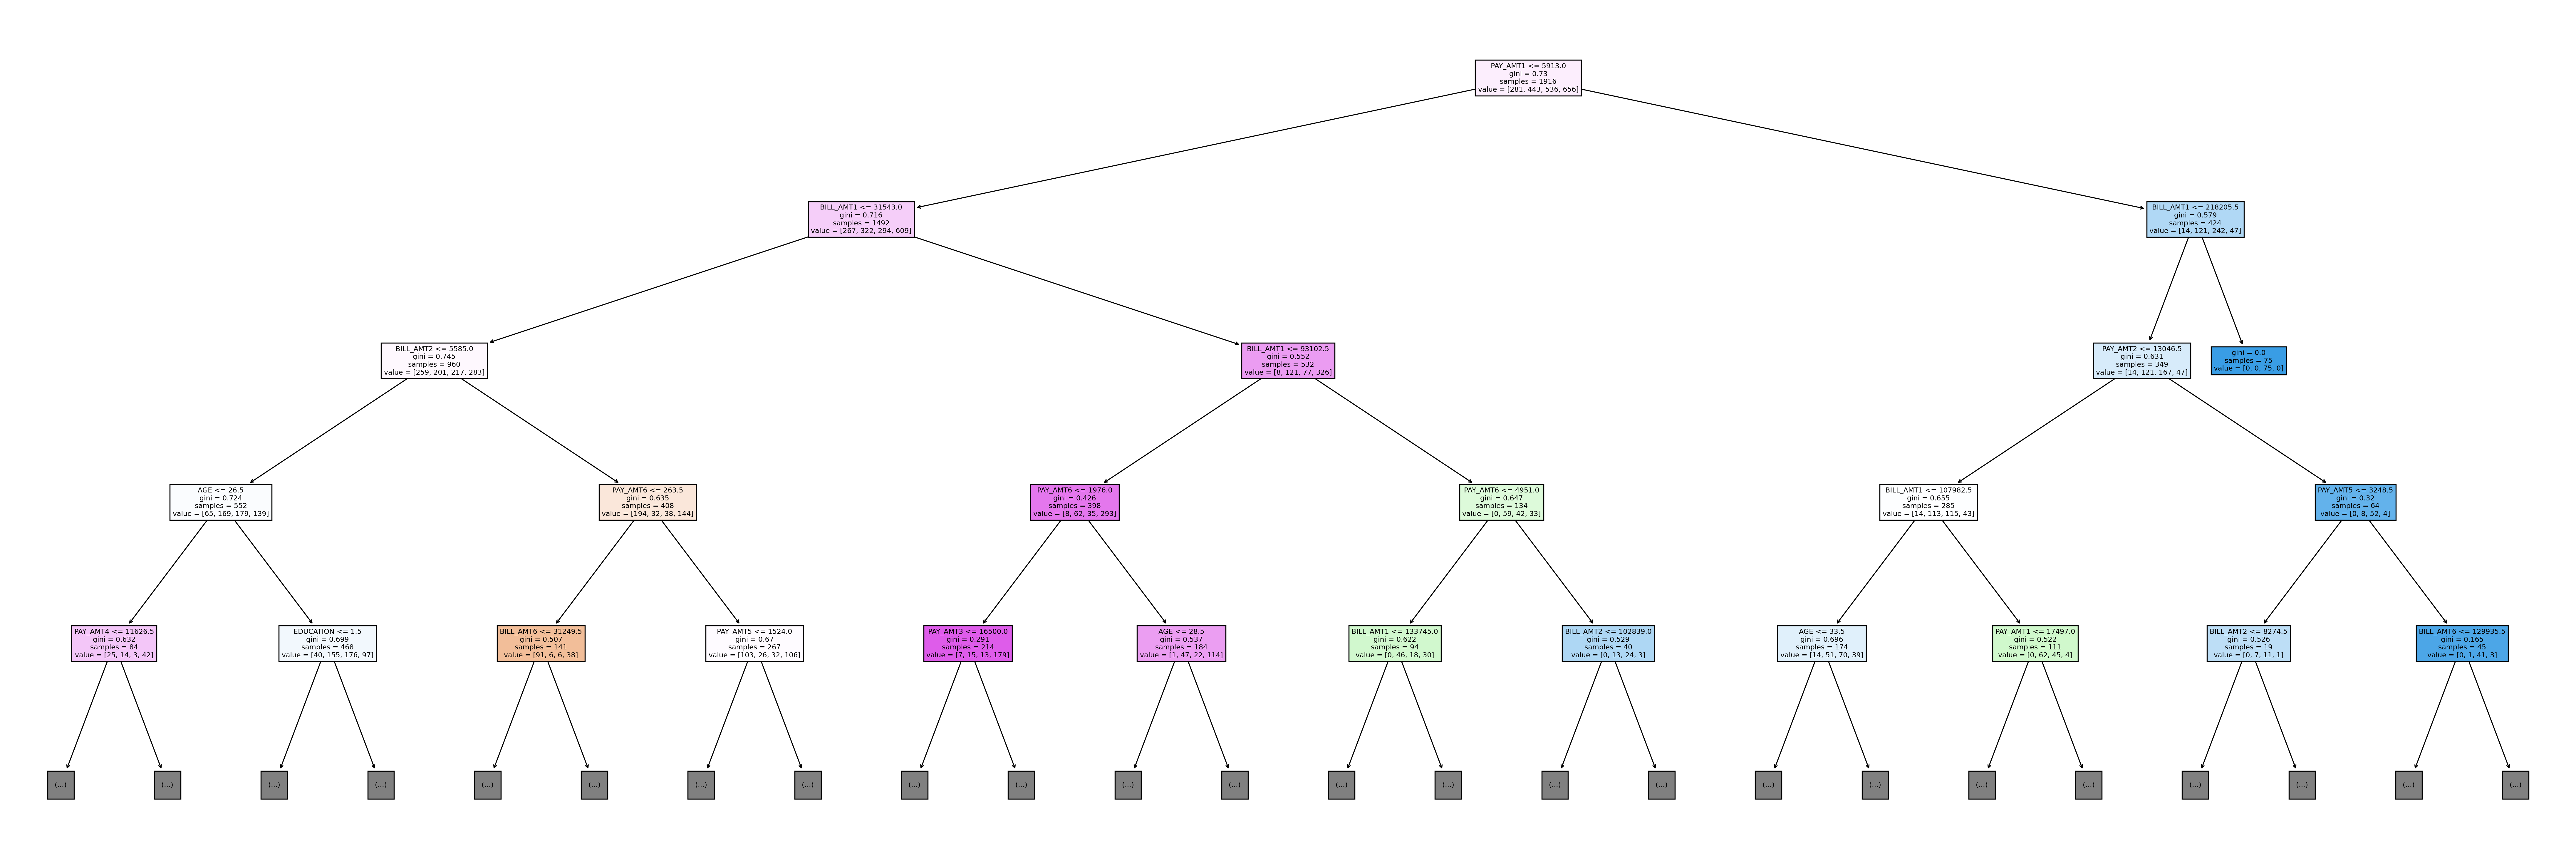

In [118]:
print('Overall (Decision Tree Classifier)')
fig = plt.figure(figsize=(45,15),dpi=250)
tree = plot_tree(model, feature_names=X.columns, filled=True, max_depth=4)